# Data Quality Assurance

## Load data

In [7]:
# import required libraries
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_hex

In [8]:
# load preprocessed dataset
raw_data_preprocessed = pd.read_pickle(pathlib.Path(r'data\\processed_data\\raw_data_preprocessed.pkl'))

# get compensated fcs data
# Get the list of unique indices
indices = raw_data_preprocessed["measurement_data_compensated"].index.get_level_values(0).unique()
# Use groupby to split the DataFrame
grouped = raw_data_preprocessed["measurement_data_compensated"].groupby(level=0)
# get fcs data as a list of dataframes of each sample
fcs_data = [grouped.get_group(index).reset_index(drop=True) for index in indices]

# get labels
indices = raw_data_preprocessed["reported_labels"].index.get_level_values(0).unique()
# Use groupby to split the DataFrame
grouped = raw_data_preprocessed["reported_labels"].groupby(level=0)
# get fcs data as a list of dataframes of each sample
labelset = [grouped.get_group(index).reset_index(drop=True) for index in indices]

cell_subsets_of_interst = ['Lympho', 'BP', 'NKP', 'TP', 'T4P', 'T8P']
# convert multiindex into columns
raw_data_preprocessed.reset_index(inplace=True, drop=False, col_level=1)
# drop first row to ease up data handling
raw_data_preprocessed = raw_data_preprocessed.droplevel(axis=1, level=0)

parents_cell_subset_of_interest = ['total', 'Lympho', 'Lympho', 'Lympho', 'Lympho', 'Lympho']

In [9]:
# Define all possible cell types
categories = ["all events", "Lympho", 'BP', 'NKP', 'TP', 'T4P', 'T8P', 'NKTP']#

viridis = plt.get_cmap('viridis')
vals = np.linspace(0, 1, len(categories))
[(val, to_hex(viridis(val))) for val in vals]
semi_viridis_hex_colors = [to_hex(viridis(val)) for val in vals]


# # Create a color dictionary
color_dict = {category: i for  category, i  in zip(categories, semi_viridis_hex_colors)}

# Add new entries
color_dict['NKT4P'] = '#fde725' # use color of NKTP
color_dict['NKT8P'] = '#fde725' # use color of NKTP
color_dict['BPNKP'] = '#ff0000' # use red to highlight illegal combination

In [10]:
# reported standard ranges of cell subset ratios from flow cytometry panel used (% of parent)
reported_ranges = pd.DataFrame({'Lympho': [18, 48], 'BP': [6, 23], 'NKP': [3, 22], 'TP': [56, 84],
                               'T4P': [31, 52], 'T8P': [18, 35]})
reported_ranges.index=['lower_bound', 'upper_bound']
reported_ranges = reported_ranges.T

In [11]:
# set dpi for all figures
plt.rcParams['figure.dpi'] = 300

## Evidence to argue DQC2

In [14]:
#load summed events of expert 1 exctraced from .txt files
summed_expert1 = pd.read_pickle(pathlib.Path(r'data\\experts_sums\\expert1_summed.pkl'))
markers = ['FSC-A', 'SSC-A', 'FITC-A', 'PE-A', 'PerCP-A', 'PE-Cy7-A', 'APC-A', 'APC-H7-A',
           'Pacific Blue-A', 'AmCyan-A']

In [15]:
checks = 0

for i in range(len(summed_expert1)):
    if (fcs_data[i].columns != markers).any():
        print('Potential error in available markers detevted at file# ', i+1)
    elif len(fcs_data[i]) != summed_expert1['total'][i]:
        print('Error detected in file', i+1)
    elif not all(dtype == 'float32' for dtype in fcs_data[i].dtypes):
        print("Error: Not all event columns are of type float32 in file# ", i+1)
    else:
        checks += 1

if checks == len(summed_expert1):
    print('All markers are available')
    print('All events are available')
    print('All events\' measurement data is available')

All markers are available
All events are available
All events' measurement data is available


**Evidence**<br>	We iterated through each FCS file loaded into a `DataFrame` and checked
1)	if the columns in the `DataFrame` match the expected markers list,
2)	ff the number of events (rows) in the `DataFrame` equals the expected totals,
3)	if all data types in the `DataFrame` columns are `float32`.
The output confirmed that all markers and all events alongside their measurement results are available.


**Conclusions**<br> All markers are available and correctly loaded into the programming environment. 
For each FCS file loaded, the total number of events matches the expected number of events.
All events only contain column data of type `float32`, indicating that no value is missing. 


### Visualize data analysis

In [16]:
import networkx as nx

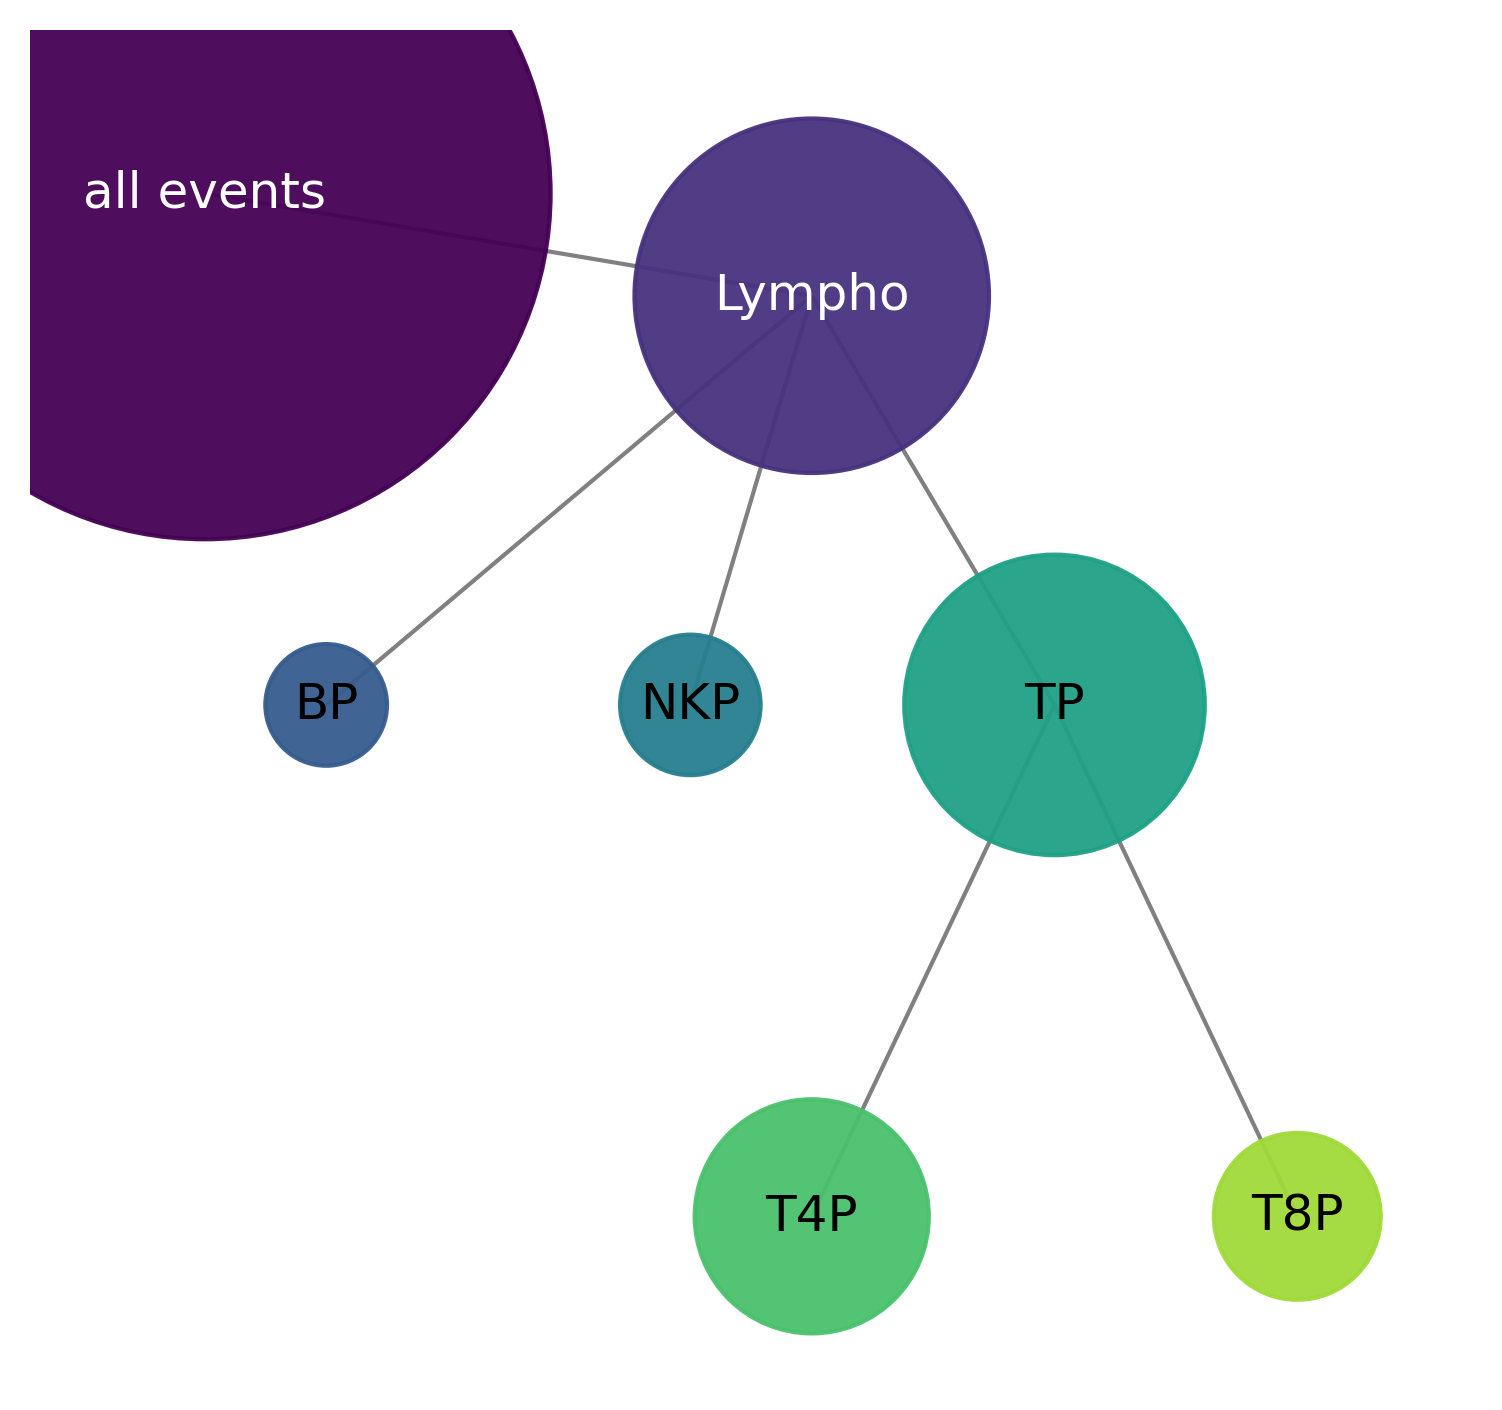

In [17]:
# use the cell network graph as pseudo leaf purity of 1
# visualize cell classification
G = nx.DiGraph()

# Add edges (relationships) to the graph
G.add_edge('all events', 'Lympho')
G.add_edge('Lympho', 'BP')
G.add_edge('Lympho', 'NKP')
G.add_edge('Lympho', 'TP')
G.add_edge('TP', 'T4P')
G.add_edge('TP', 'T8P')

# node data
node_data = {'all events': 6887776, 'Lympho': 1809869, 'BP': 213215, 
             'NKP': 284502, 'TP': 1300953, 'T4P': 789502, 'T8P': 401024
             }

# Normalize node
node_sizes = [size / 250 for size in node_data.values()]

# Specify positions
pos = {'all events': (0, 4), 'Lympho': (2.5, 3.8), 'BP': (0.5, 3), 'NKP': (2, 3), 
       'T8P': (4.5, 2), 'TP': (3.5, 3), 'T4P': (2.5, 2)}

# edge colors
edge_colors = ['red' if 'BP'in edge and 'NKP' in edge else "gray" for edge in G.edges()]

labels = {'all events': 'all events',
          'Lympho': 'Lympho',
          'BP': 'BP',
          'NKP': 'NKP',
          'TP': 'TP',
          'T4P': 'T4P',
          'T8P': 'T8P'}

node_colors = [color_dict[key] for key in node_data.keys()]

text_colors = {node: 'white' if node in ['all events', 'Lympho'] else 'black' for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8.27/2*1.5, 11.69/3*1.5))

# Draw the networkx graph (nodes and edges)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.95)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=False)

# Draw the labels with the specified text colors
for node, text_color in text_colors.items():
    nx.draw_networkx_labels(G, pos, labels={node: labels[node]}, font_color=text_color)

ax.margins(0.1)

plt.axis('off')

plt.show()

## Evidence to argue DQC3

In [24]:
from assets.functions import compare_to_standard_range
import seaborn as sns
from assets.ac_visualization import hist_standard_ranges

In [20]:
# load summed results of expert 1
summed_expert1 = pd.read_pickle(pathlib.Path(r'data/experts_sums/expert1_summed.pkl'))
# For each individual, tetermine if cell subset ratios lie within or outside the standard ranges
health_status_expert1 = pd.DataFrame()
for celltype, parent in zip(cell_subsets_of_interst, parents_cell_subset_of_interest):
    lower_bound = reported_ranges.loc[celltype, 'lower_bound']/100
    upper_bound = reported_ranges.loc[celltype, 'upper_bound']/100
    health_status_expert1.loc[:, celltype] = compare_to_standard_range(
        summed_expert1, celltype, parent, lower_bound, upper_bound
    )
    
# Boolean matrix indicating whether a cell subset lies within or outside the standard range
# True := inside of the standard range
# False := outside of the standard range
health_status_expert1

,Lympho,BP,NKP,TP,T4P,T8P
file,,,,,,
001,True,True,False,False,False,False
002,True,True,True,True,True,False
003,True,True,True,True,True,True
004,True,True,True,True,True,True
005,True,True,True,True,False,True
...,...,...,...,...,...,...
096,True,True,True,True,True,False
097,True,True,True,True,True,True
098,True,True,True,True,True,False


In [21]:
# Percentage of cell subset ratios outside of the standard ranges
1 - health_status_expert1.astype('int').sum().sum()/health_status_expert1.size

0.14166666666666672

**Evidence**<br>	Immune cell ratios were calculated as the number of cells divided by the number of all events (for lymphocytes) or divided by the number of lymphocytes (for B cells, NK cells, T cells, T helper cells, cytotoxic T cells). Immune cell ratios were compared with the standard ranges given for the panel used. We determined whether the immune cell ratios were within or outside the given standard ranges.

**Conclusion**<br> 14.2% of immune cell ratios (CRs) from expert 1's manual gating deviate from standard ranges.

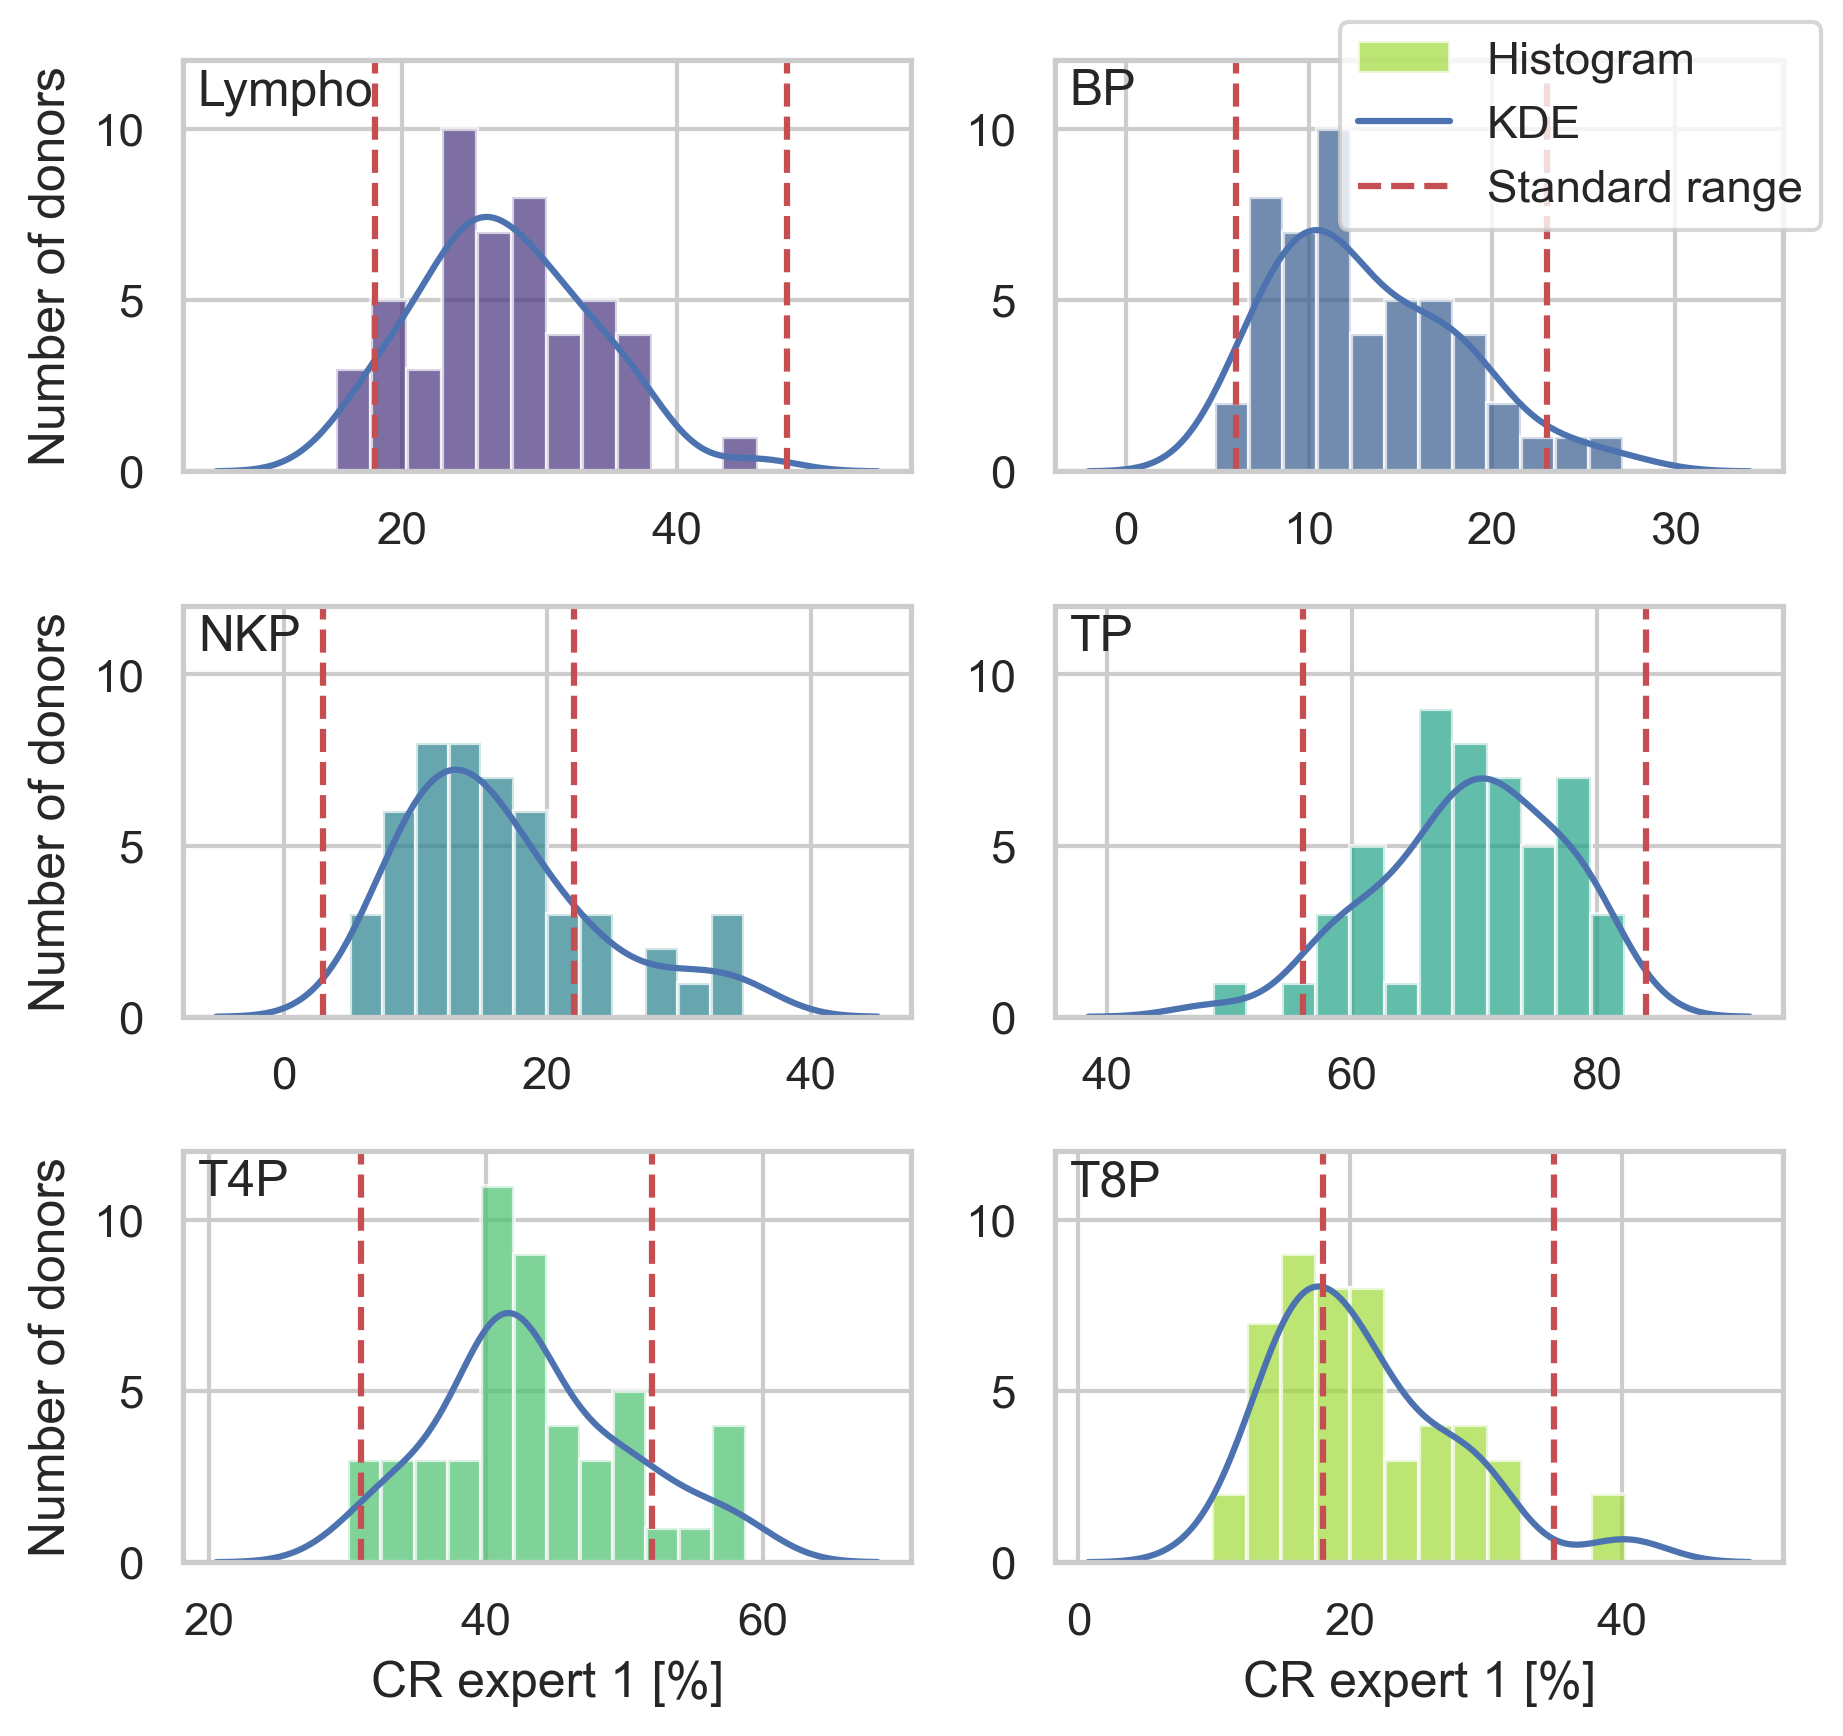

In [25]:
sns.set_theme(style='whitegrid')
hist_standard_ranges(summed_expert1, cell_subsets_of_interst,
                     parents_cell_subset_of_interest, reported_ranges,
                     color_dict)

## Evidence to argue DQC4

In [35]:
from assets.functions import determine_overlap_celltypes_all, create_multi_label
from assets.ac_visualization import cell_network_graph_dqa

In [27]:
# generate joint frequency matric
joint_frequency_matrix = determine_overlap_celltypes_all(raw_data_preprocessed, cell_subsets_of_interst)
# joint frequency matric of cell subsets of interest
joint_frequency_matrix

,Lympho,BP,NKP,TP,T4P,T8P
Lympho,1809869,213215,284502,1300953,789502,401024
BP,213215,213215,9812,0,0,0
NKP,284502,9812,284502,706,236,117
TP,1300953,0,706,1300953,789502,401024
T4P,789502,0,236,789502,789502,0
T8P,401024,0,117,401024,0,401024


In [28]:
# Calculate the percentage of "illegal" cells as a % of perent (lymphocytes)
joint_frequency_matrix.loc["BP"]["NKP"]/joint_frequency_matrix.loc["Lympho"]["Lympho"]

0.005421386851755569

In [30]:
# use a unique class map with expected label combinations (ref. immune cell hierarchy) and check if only those occur
# https://www.researchgate.net/figure/Lineage-tree-representation-of-cells-of-the-immune-system-Immune-cells-are-derived-from_fig1_335329658
# unique_class_map = {'0-0-0-0-0-0': 'None',
#                     '1-0-0-1-1-0': 'T4P',
#                     '1-1-0-0-0-0': 'BP',
#                     '1-0-1-0-0-0': 'NKP',
#                     '1-0-0-1-0-1': 'T8P',
#                     '1-0-0-1-0-0': 'TP',
#                     '1-0-1-1-1-0': 'NKT4P',
#                     '1-0-0-0-0-0': 'Lympho',
#                     '1-1-1-0-0-0': 'BPNKP',
#                     '1-0-1-1-0-0': 'NKTP',
#                     '1-0-1-1-0-1': 'NKT8P'}
unique_pred_labels = create_multi_label(raw_data_preprocessed[cell_subsets_of_interst])

c:\Programming\aicontrol\PUBLIC_aicontrol\assets\functions.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'unique_class'] = df.astype(str).\


In [34]:
np.unique(unique_pred_labels)

array(['BP', 'BPNKP', 'Lympho', 'NKP', 'NKT4P', 'NKT8P', 'NKTP', 'None',
       'T4P', 'T8P', 'TP'], dtype='<U6')

**Evidence**<br>
1) We generated a joint frequency matrix of all event cell types stored in the class matrices. In the joint frequency matrix 9812 lymphocytes are labelled as both, B cells and NK cells.
2)	We generated a list of unique cell type combinations stored in the class matrices. All cells have a consistent immune cell hierarchy.

**Conclusion**<br>
1) 9812 events belong to mutually exclusive cell subsets. In particular, there are cells that are classified as NK cells and B cells. These cells make up 0.54% of all lymphocytes. 
2) There are no cells with an inconsistent cell hierarchy.

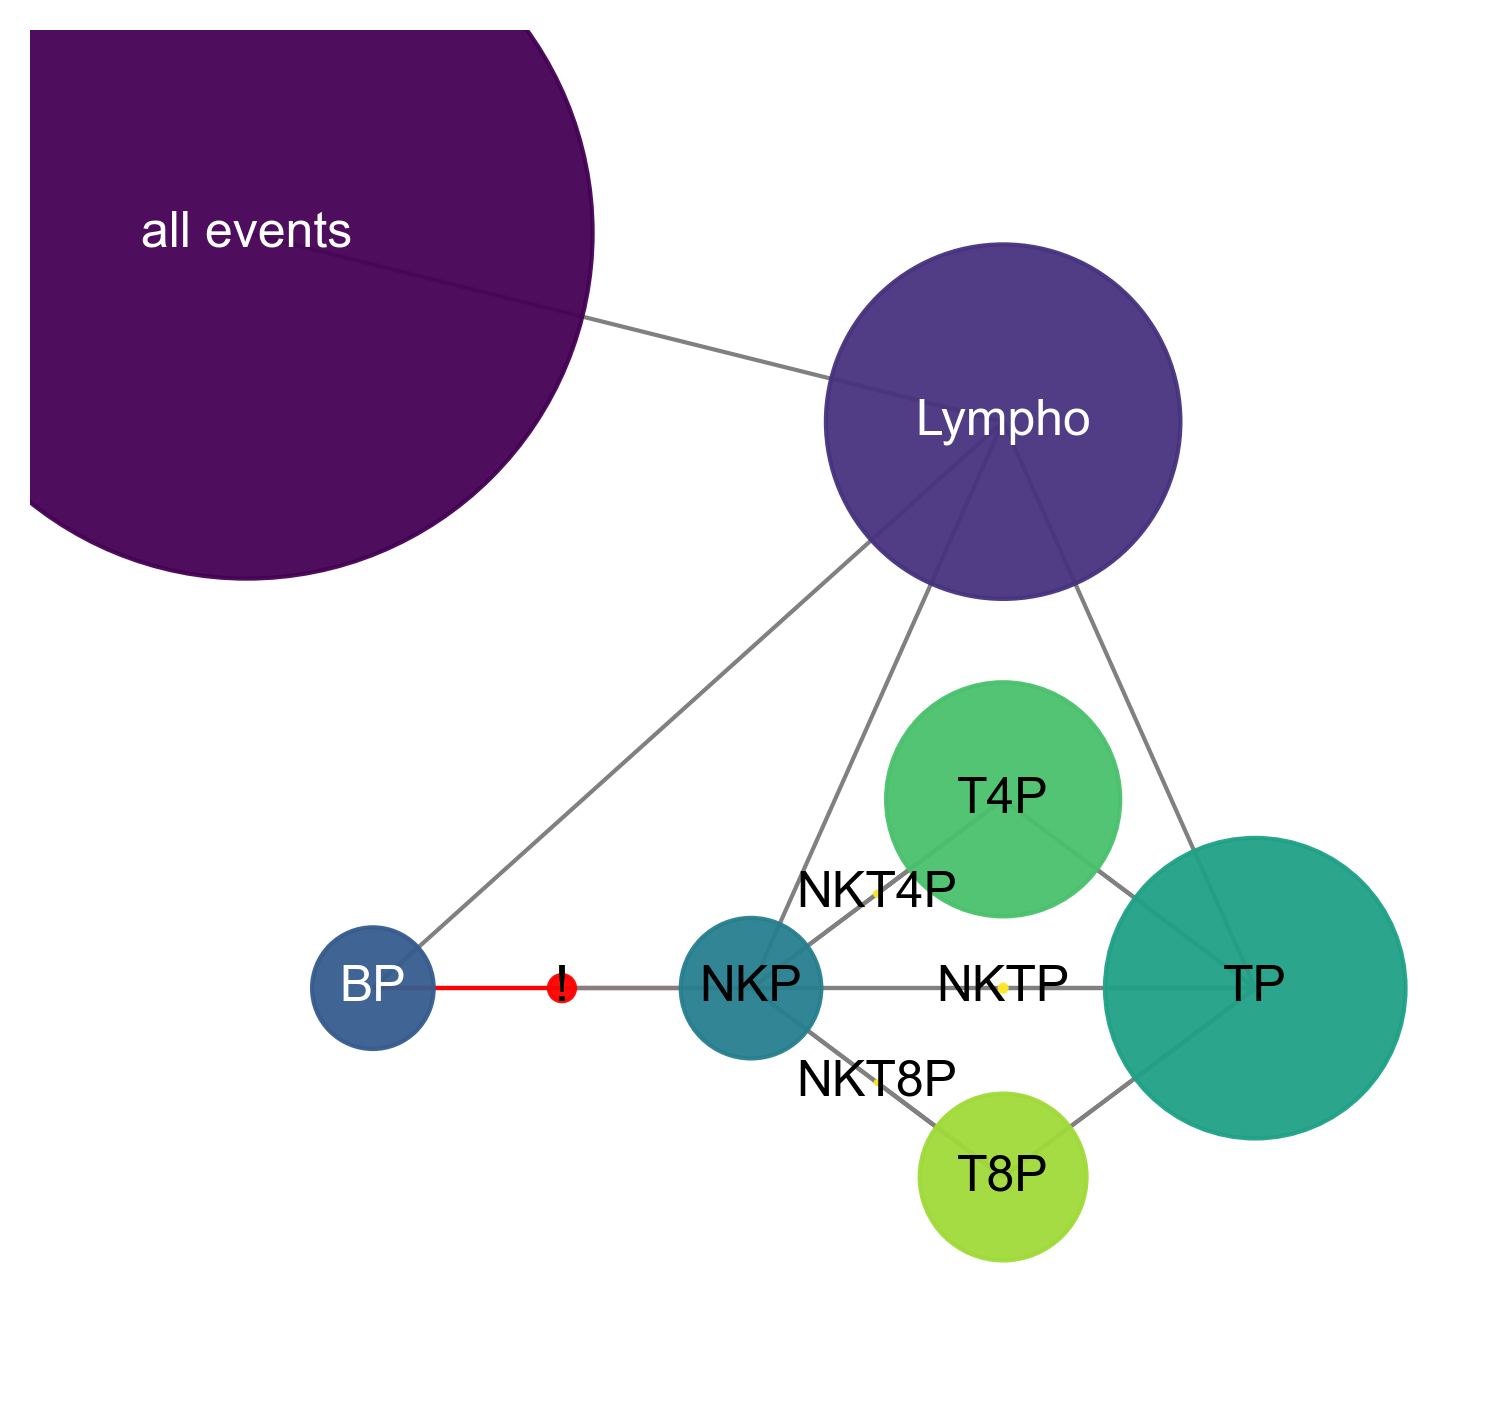

In [36]:
# visualize results as a cell network graph highlighting the annotation error from manual gating

# use cell counts from joint frequency matrix as node size
node_data = {'all events': 6887776 , 'Lympho': 1809869, 'BP': 213215, 
            'NKP': 284502, 'TP': 1300953, 'T4P': 789502, 'T8P': 401024,
            'NKTP': 706, 'NKT4P': 236, 'NKT8P': 117, 'BPNKP': 9812}
cell_network_graph_dqa(node_data=node_data, color_dict=color_dict)

## Evidence to argue DQC5

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import multilabel_confusion_matrix
from assets.functions import create_scatter
import matplotlib.lines as mlines
import matplotlib.patches as patches

In [37]:
# load summed events from manual gating
summed_expert1 = pd.read_pickle(pathlib.Path(r'data/experts_sums/expert1_summed.pkl'))
summed_expert2 = pd.read_pickle(pathlib.Path(r'data/experts_sums/expert2_summed.pkl'))

# e.g. sample 1 expert 1:
summed_expert1.loc['001']


Lympho    18566
BP         2798
NKP        6567
TP         9242
T4P        5719
T8P        2919
total     49450
Name: 001, dtype: int64

In [38]:
mae_expert2 = {}
rmse_expert2 = {}

for celltype, parent in zip(cell_subsets_of_interst, parents_cell_subset_of_interest):
    
    # calculate cell ratios as a % of parent
    expert1 = np.array(summed_expert1[celltype]/summed_expert1[parent])*100  # ground truth for model implementation
    expert2 = np.array(summed_expert2[celltype]/summed_expert2[parent])*100  # expert2 predictions for quality control

    # calculate MAE
    mae_expert2_celltype = mean_absolute_error(expert1, expert2)
    mae_expert2[celltype] = mae_expert2_celltype
    # calculate RMSE
    rmse_expert2_celltype = np.sqrt(mean_squared_error(expert1, expert2))
    rmse_expert2[celltype] = rmse_expert2_celltype

    print(f"{celltype}\n MAE  expert2 (CR [%]): {mae_expert2_celltype}\n RMSE expert2 (CR [%]): {rmse_expert2_celltype}")


Lympho
 MAE  expert2 (CR [%]): 0.27268392248235335
 RMSE expert2 (CR [%]): 0.3819326094127189
BP
 MAE  expert2 (CR [%]): 0.11001115796388505
 RMSE expert2 (CR [%]): 0.16347413611988318
NKP
 MAE  expert2 (CR [%]): 0.8212320861583174
 RMSE expert2 (CR [%]): 1.408558423253463
TP
 MAE  expert2 (CR [%]): 0.6509423608488113
 RMSE expert2 (CR [%]): 0.9664974113841293
T4P
 MAE  expert2 (CR [%]): 0.8244268477649399
 RMSE expert2 (CR [%]): 1.5567756438346658
T8P
 MAE  expert2 (CR [%]): 0.682917774314542
 RMSE expert2 (CR [%]): 0.9450477044256003


In [39]:
# For each individual, tetermine if cell subset ratios lie within or outside the standard ranges 
# for expert 2
health_status_expert2 = pd.DataFrame()
for celltype, parent in zip(cell_subsets_of_interst, parents_cell_subset_of_interest):
    lower_bound = reported_ranges.loc[celltype, 'lower_bound']/100
    upper_bound = reported_ranges.loc[celltype, 'upper_bound']/100
    health_status_expert2.loc[:, celltype] = compare_to_standard_range(
        summed_expert2, celltype, parent, lower_bound, upper_bound)

In [40]:
deviation_experts_decision = multilabel_confusion_matrix(health_status_expert1.loc['051':].astype('int'), 
                                                         health_status_expert2.loc['051':].astype('int'))
deviation_experts_decision

array([[[ 3,  0],
        [ 0, 47]],

       [[ 4,  0],
        [ 0, 46]],

       [[ 8,  2],
        [ 0, 40]],

       [[ 1,  0],
        [ 0, 49]],

       [[ 6,  0],
        [ 0, 44]],

       [[23,  0],
        [ 1, 26]]], dtype=int64)

**Evidence**<br>
Manual gating was performed twice by two independent experts. We calculated expert specific immune cell ratios for each individual. <br>
1)	The discrepancy between two experts is quantified as mean absolute error (MAE) and root mean square error (RMSE) of cell ratios across the test set (50 samples).

2)	The experts’ decisions are considered matched, if both cell ratios fall within or outside the standard range. 

**Conclusion**<br>	
1) Reference values for panel specific MAE, RMSE and allowed number of mismatches are not available. Therefore, no conclusion can be drawn whether the reference limits of inter-operator variation are exceeded.
2) The experts MAE, RMSE and the number of mismatched decisions serve as an exemplary benchmark for the model.


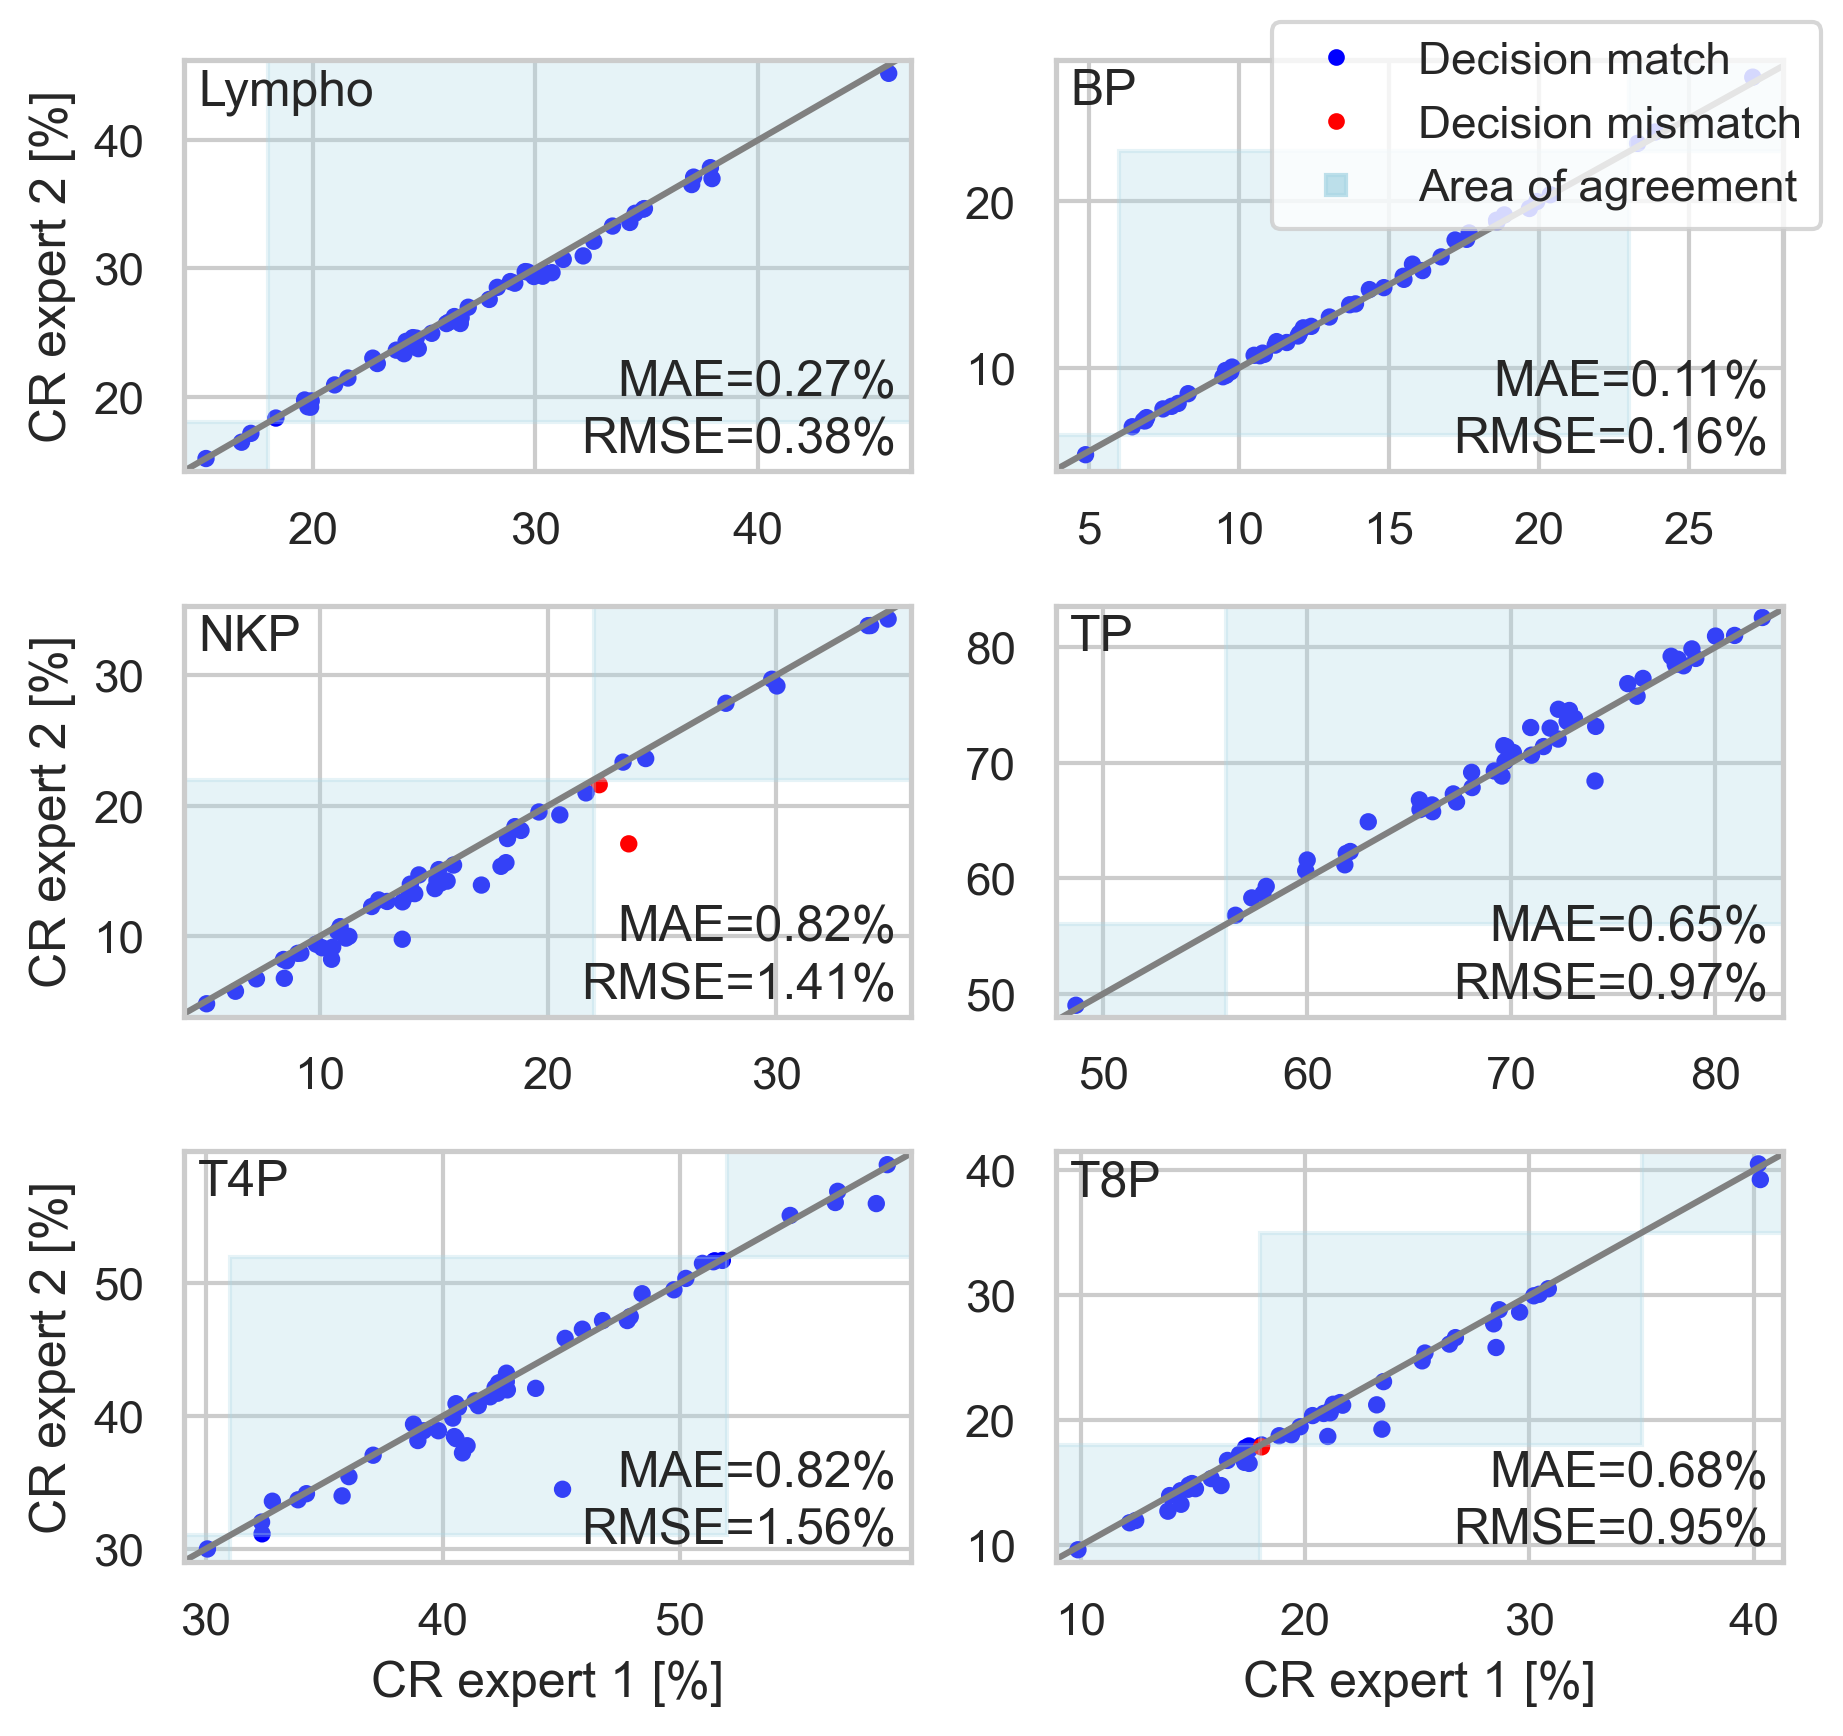

In [44]:
# visualize inter-operator variation

# Create a figure with 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(8.27/2*1.5, 11.69/3*1.5))
sns.set_theme(style='whitegrid')

# Flatten the axs array for easy iteration
axs = axs.flatten()

for idx, (ax, (celltype, parent)) in enumerate(zip(axs, zip(cell_subsets_of_interst, parents_cell_subset_of_interest))):
    fig_data = create_scatter(celltype=celltype, parent=parent, summed_expert1=summed_expert1.loc['051':], 
                         summed_expert2=summed_expert2.loc['051':])

    # Get the lower and upper bounds
    lower_bound = reported_ranges.loc[celltype, 'lower_bound']
    upper_bound = reported_ranges.loc[celltype, 'upper_bound']

    fig_data = fig_data*100

    # Create a mask for points outside the rectangles
    mask1 = (fig_data['Gating_expert1'] < lower_bound) | (fig_data['Gating_expert1'] > upper_bound) | (fig_data['Gating_expert2'] < lower_bound) | (fig_data['Gating_expert2'] > upper_bound)
    mask2 = (fig_data['Gating_expert1'] < 0) | (fig_data['Gating_expert1'] > lower_bound) | (fig_data['Gating_expert2'] < 0) | (fig_data['Gating_expert2'] > lower_bound)
    mask3 = (fig_data['Gating_expert1'] < upper_bound) | (fig_data['Gating_expert1'] > 100) | (fig_data['Gating_expert2'] < upper_bound) | (fig_data['Gating_expert2'] > 100)

    # Combine the masks
    mask = mask1 & mask2 & mask3

    # Color points based on the mask
    colors = np.where(mask, 'red', 'blue')

    ax.scatter(x=fig_data['Gating_expert1'], y=fig_data['Gating_expert2'], s=10, c=colors)
    line1 = mlines.Line2D([0, 100], [0, 100], color='gray')
    ax.add_line(line1)

    # Create a rectangle from the lower and upper bounds
    rectangle = patches.Rectangle((lower_bound, lower_bound), upper_bound-lower_bound, upper_bound-lower_bound, color='lightblue', alpha=0.3)

    agreement_area_not_healthy_lower = patches.Rectangle((0, 0), 
                                                        lower_bound, 
                                                        lower_bound, 
                                                        color='lightblue', alpha=0.3)
    ax.add_patch(agreement_area_not_healthy_lower)

    agreement_area_not_healthy_upper = patches.Rectangle((upper_bound, upper_bound), 
                                                        100 - upper_bound, 
                                                        100 - upper_bound, 
                                                        color='lightblue', alpha=0.3)
    ax.add_patch(agreement_area_not_healthy_upper)

    # Add the rectangle to the plot
    ax.add_patch(rectangle)

    # Rescale the x and y axes to the original scatter plot
    ax.set_xlim([fig_data['Gating_expert1'].min()-1, fig_data['Gating_expert1'].max()+1])
    ax.set_ylim([fig_data['Gating_expert2'].min()-1, fig_data['Gating_expert2'].max()+1])

    # Add labels and title
    if idx in [4, 5]:  # plots 5 and 6
        ax.set_xlabel('CR expert 1 [%]')
    if idx in [0, 2, 4]:  # plots 1, 3, 5
        ax.set_ylabel('CR expert 2 [%]')
    # Set title in the upper left corner
    ax.text(0.02, 0.98, celltype, transform=ax.transAxes, verticalalignment='top')
    ax.text(0.98, 0.16, 'MAE='+str(np.round(mae_expert2[celltype],2))+'%', transform=ax.transAxes, 
            verticalalignment='bottom', ha='right')
    ax.text(0.98, 0.02, 'RMSE='+str(np.round(rmse_expert2[celltype],2))+'%', transform=ax.transAxes, 
            verticalalignment='bottom', ha='right')

    # Show grid lines
    ax.grid(True)

blue_line = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=3, label='Decision match')
red_line = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=3, label='Decision mismatch')
green_line = mlines.Line2D([], [], color='lightblue', alpha=0.8, marker='s', linestyle='None', markersize=5, label='Area of agreement')

# Add the legend to the figure
fig.legend(handles=[blue_line, red_line, green_line], loc='upper right', facecolor='white', framealpha=.8)
plt.tight_layout()
plt.show()


In [45]:
performance_target_list = []
for i in range(6):
    tn, fp, fn, tp = deviation_experts_decision[i].ravel()
    performance_target_list.append([fp, fn])
performance_target_decision_level = pd.DataFrame(performance_target_list, 
                                                 columns=["FP", "FN"], index=cell_subsets_of_interst).T
performance_target = pd.concat([performance_target_decision_level, pd.DataFrame(mae_expert2, index=['MAE']),
                                pd.DataFrame(rmse_expert2, index=['RMSE'])])
performance_target

,Lympho,BP,NKP,TP,T4P,T8P
FP,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
FN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
MAE,0.272684,0.110011,0.821232,0.650942,0.824427,0.682918
RMSE,0.381933,0.163474,1.408558,0.966497,1.556776,0.945048


In [46]:
performance_target.to_pickle('data\\processed_data\\performance_target.pkl')

## Evidence to argue DQC6

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from assets.functions import named_channels

In [49]:
# the function below is always used to generate the fixed training and validation split on the first 50 samples
# use 2000 events from each fcs file
train_size = 2000
x_train, x_valid, y_train, y_valid = [], [], [], []
for i in range(0, 50):
    (x_train_loop, x_valid_loop, 
     y_train_loop, y_valid_loop,
    indices_train_loop, indices_valid_loop) = train_test_split(fcs_data[i], 
                                                               labelset[i][cell_subsets_of_interst],
                                                               labelset[i][cell_subsets_of_interst].index,
                                                               train_size=train_size, 
                                                               test_size=len(fcs_data[i])-train_size, # all remaining events are used for validation
                                                               random_state=42) # fixed random state always used
    x_train.append(x_train_loop)
    y_train.append(y_train_loop)
    x_valid.append(x_valid_loop)
    y_valid.append(y_valid_loop)

In [50]:
# exemplary classifier for feature importance analysis
rfc = RandomForestClassifier(n_estimators=120, random_state=42, n_jobs=-1)
rfc.fit(pd.concat(x_train), pd.concat(y_train))

RandomForestClassifier(n_estimators=120, n_jobs=-1, random_state=42)

In [52]:
# calculate permutation importance for the first sample in the validation set
permutation_importances = permutation_importance(rfc, pd.concat(x_valid[:1]), pd.concat(y_valid[:1]),
                                                 n_repeats=5, random_state=42, scoring='f1_micro', n_jobs=-1)

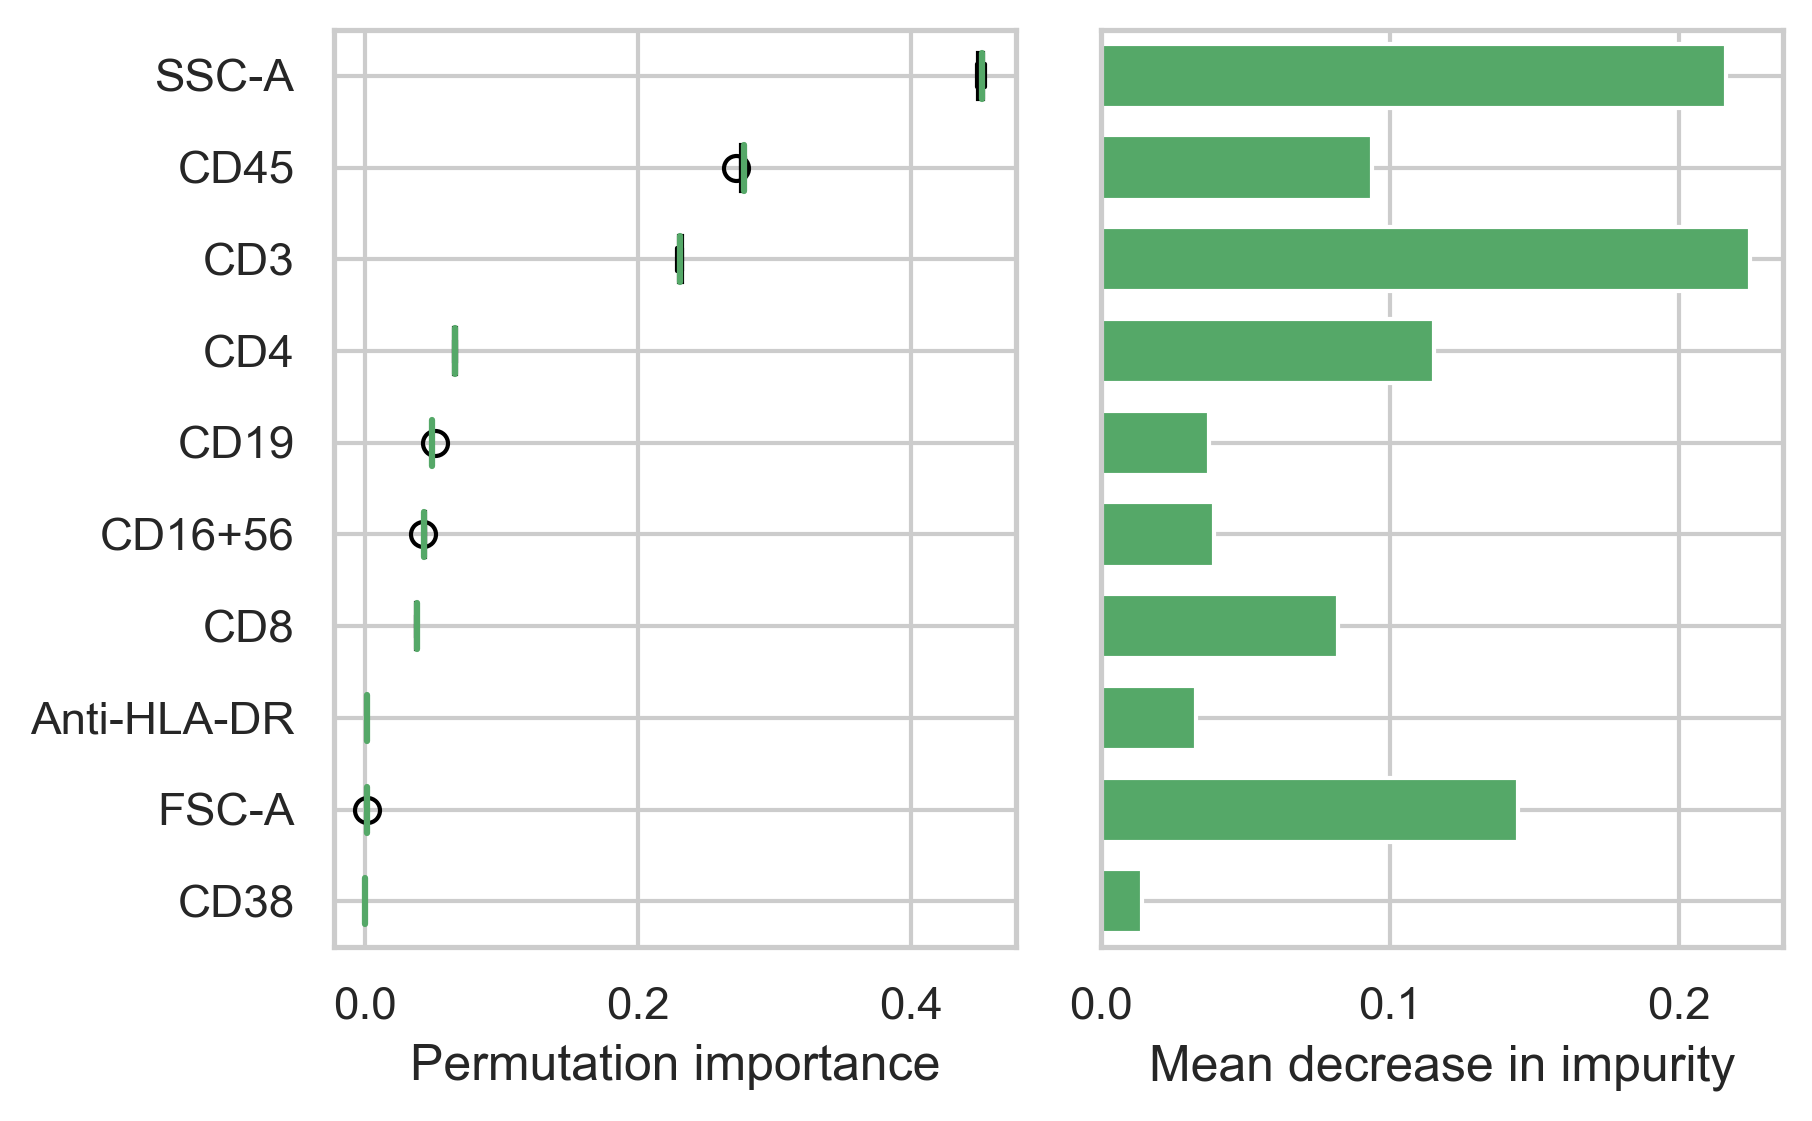

In [53]:
perm_sorted_idx = permutation_importances.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rfc.feature_importances_)
tree_indices = np.arange(0, len(rfc.feature_importances_)) + 0.5

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(8.27/2*1.5, 11.69/3))
ax1.barh(tree_indices, rfc.feature_importances_[perm_sorted_idx], height=0.7,
         color='g')
ax1.set_yticks(tree_indices)
# ax1.set_yticklabels(np.array(named_channels)[perm_sorted_idx])
ax1.set_yticklabels('')
ax1.set_ylim((0, len(rfc.feature_importances_)))
ax1.set_xlabel("Mean decrease in impurity")
ax2.boxplot(
    permutation_importances.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(named_channels)[perm_sorted_idx],
    patch_artist = True,
    boxprops = dict(facecolor = "g"),
    medianprops = dict(color = "g", linewidth = 1.5)
)
ax2.set_xlabel("Permutation importance")
fig.tight_layout()
plt.show()

In [54]:
permutation_importance_df = pd.DataFrame(permutation_importances.importances_mean[perm_sorted_idx], 
                                         index=np.array(named_channels)[perm_sorted_idx], columns=["Mean change in f1 score"])
permutation_importance_df

,Mean change in f1 score
CD38,0.000080
FSC-A,0.001227
Anti-HLA-DR,0.001229
CD8,0.037672
CD16+56,0.043140
CD19,0.049354
CD4,0.065785
CD3,0.230747
CD45,0.276111
SSC-A,0.451340


In [55]:
permutation_importance_df.iloc[3].mean()/permutation_importance_df.iloc[:3].mean()

Mean change in f1 score    44.576844
dtype: float64

**Evidence**<br>	We trained a random forest classifier using all samples from the training set and calculated the permutation importance of markers as change in the micro-averaged F1 score for the first sample in the validation set.

**Conclusions**<br>
Permutation importance is low for three markers, FSC-A, Anti-HLA-DR and CD38. The average permutation importance of these three markers is about 45 times lower than the fourth lowest marker (CD8). For the determination of lymphocytes, B cells, NK cells, T cells, T helper cells, cytotoxic T cells, these markers are not required for manual gating. <br>
However, based on the evidence no conclusion is drawn whether the three markers with the lowest permutation importance should be generally excluded or included.
